In [ ]:
# detrend temperature data, take out diurnal warming

# Pia Goecke, pia.goecke@uni-oldenburg.de
# 15.10.2024

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import pandas as pd
import matplotlib.animation as animation
import numpy as np
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import matplotlib.dates as mdates
import matplotlib as mpl
import re
from itertools import chain
import matplotlib
import matplotlib.ticker as ticker
import scipy.io
from statsmodels.nonparametric.smoothers_lowess import lowess
import gsw
from scipy.stats import pearsonr
# from matplotlib.pyplot import cm
from cartopy import config
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotx
from cycler import cycler
from matplotlib.dates import date2num
import xml.etree.ElementTree as ET
import plotly.graph_objs as go

from matplotlib import cm
import cmocean

%matplotlib qt

In [18]:
os.chdir('C:/Users/piago/Documents/Uni/5_Semester/Hiwi')
csv_file = "C:/Users/piago/Documents/Uni/5_Semester/Hiwi/Data/HE614_All_Grids_Single_Sheet.xlsx"

# Read the Excel file
df = pd.read_excel(csv_file, skiprows=10)
df = df.set_index('Date_Time')
df.index = pd.to_datetime(df.index)

In [19]:
# subset only one day 
df = df.loc['2023-03-09']
df_03_09 = df # backup

In [21]:
df.rename(columns={'CTD_Temperature_SML' : 'CTD_Temp_SML',
                   'CTD_Temperature_30cm' : 'CTD_Temperature_30cm_[°C]',
                   'CTD_Temperature_40cm' : 'CTD_Temperature_40cm_[°C]',
                   'CTD_Temperature_85cm' : 'CTD_Temperature_85cm_[°C]',
                   'CTD_Temperature_100cm' : 'CTD_Temperature_100cm_[°C]'}, inplace= True)

In [22]:
df.head()
df=df.dropna(how='all', subset=df.columns)
df.head()

,Event_label,Latitude,Longitude,Campbell_Barometric_Pressure,Campbell_Relative_Humidity,Campbell_Air_Temperature,Campbell_Dew_Point,Campbell_Wind_Speed,Campbell_Wind_Direction_True,Campbell_UVA,...,Quality_Thies_Relative_Humidity_3_AVG,Quality_Thies_Relative_Humidity_4_AVG,Quality_Thies_Relative_Humidity_5_AVG,Quality_Thies_Relative_Humidity_CUS_AVG,Precipitation_Amount,Wind_Speed_U10,Surfactant_Concentration_SML,Surfactant_Concentration_100cm,Quality_Surfactant_Concentration_SML,Quality_Surfactant_Concentration_100cm
Date_Time,,,,,,,,,,,,,,,,,,,,,
2023-03-09 07:28:00,HE614_16-03,54.878333,7.126683,997.3,61,3.2,-3.3,4.83,122,10.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-09 07:28:10,HE614_16-03,54.878333,7.126700,997.4,63,3.1,-3.1,3.57,124,11.62,...,NaN,NaN,NaN,NaN,NaN,3.378647,NaN,NaN,NaN,NaN
2023-03-09 07:28:20,HE614_16-03,54.878167,7.126717,997.4,63,3.1,-3.1,3.57,124,11.62,...,NaN,NaN,NaN,NaN,NaN,3.252706,NaN,NaN,NaN,NaN
2023-03-09 07:28:30,HE614_16-03,54.878000,7.126750,997.4,63,3.1,-3.1,3.57,124,11.62,...,NaN,NaN,NaN,NaN,NaN,3.716414,NaN,NaN,NaN,NaN
2023-03-09 07:28:40,HE614_16-03,54.878000,7.126833,997.4,63,3.2,-3.1,3.84,117,11.72,...,NaN,NaN,NaN,NaN,NaN,3.292637,NaN,NaN,NaN,NaN


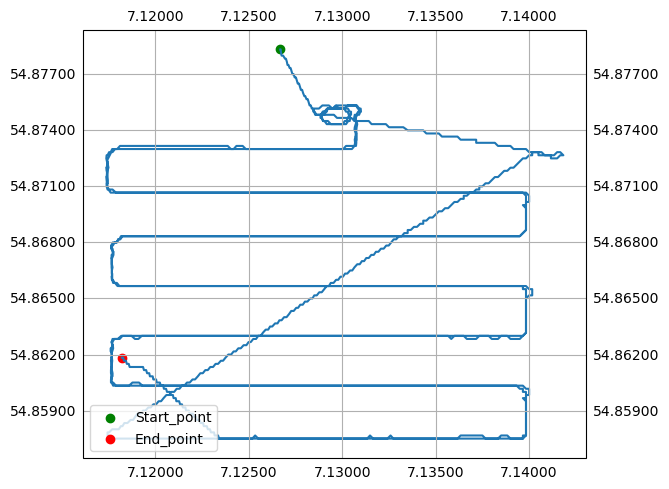

In [5]:
track2_lons = df.Longitude
track2_lats = df.Latitude
import matplotlib.ticker as mticker


# Define the format for x and y-axis ticks
formatter = mticker.FuncFormatter(lambda x, _: '{:.2f}'.format(x))

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())


ax.plot(track2_lons, track2_lats)
plt.scatter(df.Longitude[0],df.Latitude[0], color = 'green', label = 'Start_point')
plt.scatter(df.Longitude[-1],df.Latitude[-1], color = 'red', label = 'End_point')


# Show gridlines
gl = ax.gridlines(draw_labels=True)

# Set tick formatter for x and y-axis
gl.xformatter = mticker.FormatStrFormatter('%.5f')
gl.yformatter = mticker.FormatStrFormatter('%.5f')

ax.legend(loc='lower left')
plt.tight_layout()
#plt.savefig(f'C:/Users/piago/Documents/Uni/5_Semester/Hiwi/Plots/Grid_20230309')

plt.show()


In [6]:
# Filter columns that start with "CTD_Temp"
filtered_columns = [col for col in df.columns if col.startswith('CTD_Temp')]

# Create the plotly figure
fig = go.Figure()

for i, col in enumerate(filtered_columns):
    mode = 'lines+markers' if i % 2 == 0 else 'markers'
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df[col],
        mode='lines',
        marker = dict(size=2),
        name=col[-10:]
    ))

# Customize the layout
fig.update_layout(
    title='Halobates Temperature',
    xaxis_title='Time',
    yaxis_title='Temperature',
    template='plotly_white',
    width=800,  # Set the width of the figure
    height=300,  # Set the height of the figure
    legend=dict(
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=8,
            color='black'
        ),
    ),
    margin=dict(l=40, r=40, t=40, b=40)  # Customize margins
)


# Set x and y axis limits
fig.update_xaxes(range=[df.index.min(), df.index.max()],
                title_font=dict(size=18, family='Arial Black, sans-serif', color='black'),
                tickfont=dict(size=14) 
) #ncrease y-axis tick font size# Adjust as needed


fig.update_yaxes(#range=[17,18.5],
                title_font=dict(size=18, family='Arial Black, sans-serif', color='black'),
                tickfont=dict(size=14)  # Increase y-axis tick font size
)  # Adjust as needed

# Show the plot
fig.show()

In [7]:
# Filter columns that start with "Campbell_air"
filtered_columns = [col for col in df.columns if col.startswith('Campbell_Air')]


# Create the plotly figure
fig = go.Figure()

for i, col in enumerate(filtered_columns):
    mode = 'lines+markers' if i % 2 == 0 else 'markers'
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df[col],
        mode='lines',
        marker = dict(size=2),
        name=col[-12:-6]
    ))

# Customize the layout
fig.update_layout(
    title='Air Temperature',
    xaxis_title='Time',
    yaxis_title='Temperature',
    #legend_title='Legend',
    template='plotly_white',
    width=800,  # Set the width of the figure
    height=300,  # Set the height of the figure
    legend=dict(
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=8,
            color='black'
        ),
    ),
    margin=dict(l=40, r=40, t=40, b=40)  # Customize margins
)


# Set x and y axis limits
fig.update_xaxes(range=[df.index.min(), df.index.max()],
                title_font=dict(size=18, family='Arial Black, sans-serif', color='black'),
                tickfont=dict(size=14) 
) #ncrease y-axis tick font size# Adjust as needed

fig.update_yaxes(#range=[17,18.5],
                title_font=dict(size=18, family='Arial Black, sans-serif', color='black'),
                tickfont=dict(size=14)  # Increase y-axis tick font size
)  # Adjust as needed


# Show the plot
fig.show()

In [49]:
df = df_03_09

In [51]:
df.head()

,Event_label,Latitude,Longitude,Campbell_Barometric_Pressure,Campbell_Relative_Humidity,Campbell_Air_Temperature,Campbell_Dew_Point,Campbell_Wind_Speed,Campbell_Wind_Direction_True,Campbell_UVA,...,Wind_Speed_U10,Surfactant_Concentration_SML,Surfactant_Concentration_100cm,Quality_Surfactant_Concentration_SML,Quality_Surfactant_Concentration_100cm,time_numeric,fitted_1_Temp_SML,detrend_1_Temp_SML,fitted_2_Temp_SML,detrend_2_Temp_SML
Date_Time,,,,,,,,,,,,,,,,,,,,,
2023-03-09 07:28:00,HE614_16-03,54.878333,7.126683,997.3,61,3.2,-3.3,4.83,122,10.59,...,NaN,NaN,NaN,NaN,NaN,0.0,5.612201,5.719590,5.402969,5.928823
2023-03-09 07:28:10,HE614_16-03,54.878333,7.126700,997.4,63,3.1,-3.1,3.57,124,11.62,...,3.378647,NaN,NaN,NaN,NaN,10.0,5.612404,5.706688,5.403664,5.915428
2023-03-09 07:28:20,HE614_16-03,54.878167,7.126717,997.4,63,3.1,-3.1,3.57,124,11.62,...,3.252706,NaN,NaN,NaN,NaN,20.0,5.612606,5.705385,5.404358,5.913633
2023-03-09 07:28:30,HE614_16-03,54.878000,7.126750,997.4,63,3.1,-3.1,3.57,124,11.62,...,3.716414,NaN,NaN,NaN,NaN,30.0,5.612809,5.704883,5.405053,5.912639
2023-03-09 07:28:40,HE614_16-03,54.878000,7.126833,997.4,63,3.2,-3.1,3.84,117,11.72,...,3.292637,NaN,NaN,NaN,NaN,40.0,5.613011,5.712280,5.405746,5.919545


In [50]:
# drop outlier in SML temtime series
print(f'values larger than 6.2: {sum(df['CTD_Temp_SML']>6.2)}') # one outlier
df.drop(df[df['CTD_Temp_SML']>6.2].index, inplace = True)
print(f'values larger than 6.2: {sum(df['CTD_Temp_SML']>6.2)}')


values larger than 6.2: 0
values larger than 6.2: 0


In [52]:
#Detrending SML temperature with numpy poylonialfit

# time in total seconds
df['time_numeric'] = (df.index - df.index.min()).total_seconds()  

# fit polynomial with numpy.polyfit: linear and quadratic

degrees = [1,2]
for degree in degrees:
    coefficients = np.polyfit(df['time_numeric'], df['CTD_Temp_SML'], degree) # fit polynomial
    polynomial = np.poly1d(coefficients) #create function
    df[f'fitted_{degree}_Temp_SML'] = polynomial(df['time_numeric']) #values
    df[f'detrend_{degree}_Temp_SML'] = df['CTD_Temp_SML'] - df[f'fitted_{degree}_Temp_SML']
    df[f'detrend_{degree}_Temp_SML'] = df[f'detrend_{degree}_Temp_SML'] + df[f'fitted_{degree}_Temp_SML'].mean()


In [25]:
#PLOT
for i in [1,2]:
    plt.figure(i, figsize=(12, 6))

    # Plot original water temperature
    plt.subplot(2, 1, 1)
    plt.scatter(df.index, df['CTD_Temp_SML'], label='Observed SML Temp', color='blue', s=10)
    plt.plot(df.index, df[f'fitted_{i}_Temp_SML'], label=f'Fitted Polynomial {i}-degree', color='red')
    plt.title(f'Observed SML Temp and {i}-degree fit', fontsize = 18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylabel('Temperature', fontsize = 15)
    plt.legend(fontsize = 12)

    # Plot detrended water temperature
    plt.subplot(2, 1, 2)
    plt.scatter(df.index, df[f'detrend_{i}_Temp_SML'], label='Detrended SML Temp', color='green', s=10)
    plt.title(f'Detrended SML Temp {i}-degree', fontsize = 18)
    plt.xlabel('Time', fontsize = 15)
    plt.ylabel('Detrended Temperature', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(fontsize = 12)

    plt.tight_layout()
    plt.show()

    #plt.savefig(f'C:/Users/piago/Documents/Uni/5_Semester/Hiwi/Plots/Polynomial_fit_{degrees[i-1]}_degree')

#######
# 2-degree looks better
#######


In [28]:
plt.figure(figsize = (12,8))
plt.scatter(df.index, df['CTD_Temp_SML'], color = 'blue', label = 'observed Temperature')
plt.plot(df.index, df[f'fitted_2_Temp_SML'], label=f'quadratic fit', color='red', linewidth = 3)
# plt.scatter(df.index, df['detrend_2_Temp_SML'], color = 'orange', label = 'detrended Temperature')

plt.title(f'SML Temperature (09.03.)', fontsize = 25)
plt.xlabel('Time UTC', fontsize = 20)
plt.ylabel('Temperature [°C]', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20,loc = 'lower right')

plt.tight_layout()
plt.show()


In [40]:
# plot each run of grid to check results (runs should look +- the same)
df_first = df[df['time_numeric']<(df['time_numeric'].max())*0.5] # first run 
df_second = df[df['time_numeric']>=(df['time_numeric'].max())*0.5] # second run

runs = [df_first, df_second]

In [41]:
#both runs for observed T
plt.figure(1,figsize=(8,8))
for i in [0,1]:
    plt.subplot(2,1,i+1)
    plt.scatter(runs[i].Longitude, runs[i].Latitude, c = runs[i]['CTD_Temp_SML'], cmap = 'coolwarm', vmin = 5.2, vmax = 6.2)
    cbar = plt.colorbar(cmap='coolwarm', pad=0.03)
    cbar.set_label('Temperature [°C]', fontsize=20)
    cbar.ax.tick_params(labelsize=15)
    plt.title(f'observed SML temperature {i+1}. half', fontsize = 20)
    plt.ylabel('Latitude', fontsize = 15)
    if i == 1:
        plt.xlabel('Longitude',fontsize = 15)

plt.tight_layout(pad=2.0)

#both runs for detrended T
plt.figure(2,figsize=(8,8))
for i in [0,1]:
    plt.subplot(2,1,i+1)
    plt.scatter(runs[i].Longitude, runs[i].Latitude, c = runs[i]['detrend_2_Temp_SML'], cmap = 'coolwarm', vmin = 5.7, vmax = 6.0)
    cbar = plt.colorbar(cmap='coolwarm', pad=0.03)
    cbar.set_label('Temperature [°C]', fontsize=20)
    cbar.ax.tick_params(labelsize=15)
    plt.title(f'detrended SML temperature {i+1}. half', fontsize = 20)
    plt.ylabel('Latitude', fontsize = 15)
    if i == 1:
        plt.xlabel('Longitude',fontsize = 15)

plt.tight_layout(pad=2.0)



In [71]:
df =df_03_09

In [72]:
# detrend RBR temperature
depths = [30, 40, 50, 60, 85, 100]
for d in depths:
    if df[f'RBR_Temperature_{d}cm'].dropna().empty:
        print(f"Column RBR_Temperature_{d}cm is empty or contains only NaN values. creating nan-column for depth {d}.")
    else: 
        coefficients = np.polyfit(df['time_numeric'], df[f'RBR_Temperature_{d}cm'], 2) # fit polynomial
        polynomial = np.poly1d(coefficients) #create function
        df[f'rbr_fitted_2_Temp_{d}'] = polynomial(df['time_numeric']) #values
        df[f'rbr_detrend_2_Temp_{d}'] = df[f'RBR_Temperature_{d}cm'] - df[f'rbr_fitted_2_Temp_{d}']
        df[f'rbr_detrend_2_Temp_{d}'] = df[f'rbr_detrend_2_Temp_{d}'] + df[f'rbr_fitted_2_Temp_{d}'].median()

# same for CTD all depths
depths = [30, 40, 60, 85, 100]

for d in depths:
    coefficients = np.polyfit(df['time_numeric'], df[f'CTD_Temperature_{d}cm_[°C]'], degree) # fit polynomial
    polynomial = np.poly1d(coefficients) #create function
    df[f'fitted_2_Temp_{d}'] = polynomial(df['time_numeric']) #values
    df[f'detrend_2_Temp_{d}'] = df[f'CTD_Temperature_{d}cm_[°C]'] - df[f'fitted_2_Temp_{d}']
    df[f'detrend_2_Temp_{d}'] = df[f'detrend_2_Temp_{d}'] + (df[f'CTD_Temperature_{d}cm_[°C]'][0] - df[f'detrend_2_Temp_{d}'][0])

    # #PLOT 
    # plt.figure( figsize=(10, 8))

    # # Plot original water temperature
    # plt.subplot(2, 1, 1)
    # plt.scatter(df.index, df[f'CTD_Temperature_{d}cm_[°C]'], label=f'Observed Temp {d}cm', color='blue', s=10)
    # plt.plot(df.index, df[f'fitted_2_Temp_{d}'], label=f'Fitted Polynomial 2-degree', color='red')
    # plt.title(f'Observed {d}cm Temp and 2-degree fit')
    # plt.ylabel('Temperature')
    # plt.legend()

    # # Plot detrended water temperature
    # plt.subplot(2, 1, 2)
    # plt.scatter(df.index, df[f'detrend_2_Temp_{d}'], label=f'Detrended Temp {d}cm', color='green', s=10)
    # plt.title(f'Detrended {d}cm Temp 2-degree')
    # plt.xlabel('Time')
    # plt.ylabel('Detrended Temperature')
    # plt.legend()

    # plt.tight_layout()
    # plt.show()

# devide runs
df_first = df[df['time_numeric']<(df['time_numeric'].max())*0.5] # first run 
df_second = df[df['time_numeric']>=(df['time_numeric'].max())*0.5] # second run

runs = [df_first, df_second]

In [75]:
# second run, CTD and RBR
df = df_second

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.scatter(df.Longitude, df.Latitude, c = df['detrend_2_Temp_30'], cmap = 'coolwarm')#, vmin = 5.7, vmax = 6.05)
cbar = plt.colorbar(cmap='coolwarm', pad=0.03)
cbar.set_label('Temperature [°C]', fontsize=15)
cbar.ax.tick_params(labelsize=15)
plt.title(f'CTD Temperature 30 cm', fontsize = 20)
plt.ylabel('Latitude', fontsize = 15)
#plt.xlabel('Longitude',fontsize = 15)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)


plt.subplot(2,1,2)
plt.scatter(df.Longitude, df.Latitude, c = df['rbr_detrend_2_Temp_30'], cmap = 'coolwarm')#, vmin = 5.7, vmax = 6.05)
cbar = plt.colorbar(cmap=cmocean.cm.thermal, pad=0.03)
cbar.set_label('Temperature [°C]', fontsize=15)
cbar.ax.tick_params(labelsize=15)
plt.title(f'RBR Temperature 30 cm', fontsize = 20)
plt.ylabel('Latitude', fontsize = 15)
plt.xlabel('Longitude',fontsize = 15)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)

plt.tight_layout(pad = 2.0)

In [76]:
#both runs for detrended T, better cmap-range
plt.figure(2,figsize=(10,8))
for i in [0,1]:
    plt.subplot(2,1,i+1)
    plt.scatter(runs[i].Longitude, runs[i].Latitude, c = runs[i]['detrend_2_Temp_SML'], cmap = cmocean.cm.thermal, vmin = 5.7, vmax = 6.05)
    cbar = plt.colorbar(cmap=cmocean.cm.thermal, pad=0.03)
    cbar.set_label('Temperature [°C]', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    plt.title(f'Temperature SML {i+1}. run', fontsize = 20)
    plt.ylabel('Latitude', fontsize = 15)
    if i ==1: 
        plt.xlabel('Longitude',fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    #plt.savefig(f'C:/Users/piago/Documents/Uni/5_Semester/Hiwi/Plots/Detrended_grids_SML')
    
plt.tight_layout(pad=2.0)

#########################
# looks better. 
# 1. run: higher temperatures when Halobates goes from east to west
# 2. run: higher temperatures when Halobates goes from west to east.
# Why?
#########################

In [77]:

#PLOT  100 cm
plt.figure( figsize=(10, 8))

# Plot original water temperature
plt.subplot(2, 1, 1)
plt.scatter(df.index, df['CTD_Temperature_100cm_[°C]'], label='Observed Temp 100cm', color='blue', s=10)
plt.plot(df.index, df['fitted_2_Temp_100'], label='Fitted Polynomial 2-degree', color='red')
plt.title('Observed 100cm Temp and 2-degree fit')
plt.ylabel('Temperature')
plt.legend()

# Plot detrended water temperature
plt.subplot(2, 1, 2)
plt.scatter(df.index, df['detrend_2_Temp_100'], label='Detrended Temp 100cm', color='green', s=10)
plt.title('Detrended 100cm Temp 2-degree')
plt.xlabel('Time')
plt.ylabel('Detrended Temperature')
plt.legend()

plt.tight_layout()
plt.show()


In [79]:
#both runs for observed T
plt.figure(1,figsize=(12,6))
for i in [0,1]:
    plt.subplot(2,1,i+1)
    plt.scatter(runs[i].Longitude, runs[i].Latitude, c = runs[i]['CTD_Temperature_100cm_[°C]'], cmap = 'coolwarm', vmin = 5.4, vmax = 6.2)
    cbar = plt.colorbar(cmap='coolwarm', pad=0.03)
    cbar.set_label('Temp_100cm' + '\n' + 'observed', fontsize=15)
    plt.title(f'Temp_100cm_{i+1}._gridrun', fontsize = 20)
    plt.ylabel('Latitude', fontsize = 15)
    if i == 1:
        plt.xlabel('Longitude',fontsize = 15)

plt.tight_layout(pad=2.0)

#both runs for detrended T
plt.figure(2,figsize=(12,6))
for i in [0,1]:
    plt.subplot(2,1,i+1)
    plt.scatter(runs[i].Longitude, runs[i].Latitude, c = runs[i]['detrend_2_Temp_100'], cmap = 'coolwarm', vmin = 5.4, vmax = 6.2)
    cbar = plt.colorbar(cmap='coolwarm', pad=0.03)
    cbar.set_label('Temp_100cm' + '\n' + 'detrended', fontsize=15)
    plt.title(f'Temp_100cm_{i+1}._gridrun', fontsize = 20)
    plt.ylabel('Latitude', fontsize = 15)
    if i == 1:
        plt.xlabel('Longitude',fontsize = 15)

plt.tight_layout(pad=2.0)

In [80]:
#both runs for detrended T, better cmap-range
plt.figure(2,figsize=(10,8))
for i in [0,1]:
    plt.subplot(2,1,i+1)
    plt.scatter(runs[i].Longitude, runs[i].Latitude, c = runs[i]['detrend_2_Temp_100'], cmap = 'coolwarm', vmin = 5.4, vmax = 5.7)
    cbar = plt.colorbar(cmap='coolwarm', pad=0.03)
    cbar.set_label('Temp_100cm' + '\n' + 'detrended', fontsize=15)
    plt.title(f'Temp_100cm_{i+1}._gridrun', fontsize = 20)
    plt.ylabel('Latitude', fontsize = 15)
    plt.xlabel('Longitude',fontsize = 15)

plt.tight_layout(pad=2.0)


############
# same as befor with Surface layer:
# 1. run: higher temperatures when Halobates goes from east to west
# 2. run: higher temperatures when Halobates goes from west to east.
# ?
############

In [81]:
# plot detrend for all depths, both runs

for d in range(len(depths)):
    plt.figure(d+1,figsize=(10,8))
    for i in [0,1]:
        plt.subplot(2,1,i+1)
        plt.scatter(runs[i].Longitude, runs[i].Latitude, c = runs[i][f'detrend_2_Temp_{depths[d]}'], cmap = 'coolwarm', vmin = 5.2, vmax = 5.65)
        cbar = plt.colorbar(cmap='coolwarm', pad=0.03)
        cbar.set_label(f'Temp_{depths[d]}cm' + '\n' + 'detrended', fontsize=15)
        plt.title(f'Temp_{depths[d]}cm_{i+1}._gridrun', fontsize = 20)
        plt.ylabel('Latitude', fontsize = 15)
        if i == 1:
            plt.xlabel('Longitude',fontsize = 15)
        #plt.savefig(f'C:/Users/piago/Documents/Uni/5_Semester/Hiwi/Plots/Detrended_grids_{depths[d]}_cm')

    plt.tight_layout(pad=2.0)

In [83]:
# spatial Temperature detrended

fig,ax = plt.subplots(nrows=1, figsize=(18,6))#, sharex=True)  # sharey=True,
#x_numeric = np.sin(dept) 
df = df.dropna(subset= ['detrend_2_Temp_100'])
xi = np.linspace(min(df.Longitude), max(df.Longitude))
yi = np.linspace(min(df.Latitude),max(df.Latitude))
#xi, yi = np.meshgrid(xi, yi)
#zi = griddata((x_numeric, combined_df.Depth), combined_df.T_smooth.values, (xi[None,:], yi[:,None]), method='linear')

zi = griddata((df.Longitude,df.Latitude), df['detrend_2_Temp_100'], (xi[None,:], yi[:,None]), method='linear')

plt.grid()
plt.contourf(xi,yi,zi, 15,cmap='coolwarm')
#ax.invert_yaxis()
#plt.pcolormesh(xi, yi,zi,cmap='plasma')
#plt.scatter(xi,yi,c=zi)
#plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S'))
#plt.gca().yaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
cbar = plt.colorbar(cmap='coolwarm', pad=0.03)
cbar.set_label('Detrended Temperature [°C]', fontsize=18, fontweight='bold')
cbar.ax.tick_params(axis='y', which='both', labelsize=14, width=2)  # Adjust length and width as desired

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim(0.7,10.3)
#[plt.axhline(y=i, color='g', linestyle = '-') for i in dep_lines]
#[plt.axhline(y=i, color='w', linestyle = '-') for i in dep_lines_SnS]
plt.xlabel("Longitude", fontsize=18, fontweight='bold')
plt.ylabel("Latitiude", fontsize=18, fontweight='bold')
plt.title('Temperature_Spatial_Detrended 100cm',fontsize=22, fontweight='bold')
plot_name = 'Temperature_Spatial_Detrended'
#absolute_plotname = absolute_path_to_plots / plot_name
#plt.savefig(absolute_plotname,dpi=600)
#plt.savefig('C:/Users/Samuel Mintah Ayim/OneDrive - Carl von Ossietzky Universität Oldenburg/Documents/Projects/Front_Analysis/SML_Sal_Contour.png',dpi=600)

Second Idea: Find correlation between air temperature and water temperature

In [93]:
df = df_03_09

In [94]:
###
# Assume linear dependency between air-Temp and SML-Temp.
# Ordinary least square regression (linear) for correlation between air temperature and SML temperature
###

import statsmodels.api as sm

# Set up your independent and dependent variables
X = df['Campbell_Air_Temperature']
y = df['CTD_Temp_SML']

# Add a constant for the intercept (doesn't have to cross 0/0-point)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

#####
# r2-value = 0.475
#####

                            OLS Regression Results                            
Dep. Variable:           CTD_Temp_SML   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     2317.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:32:02   Log-Likelihood:                 1482.1
No. Observations:                2549   AIC:                            -2960.
Df Residuals:                    2547   BIC:                            -2949.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [95]:
#calculate OSL-Corrected SML-Temperatures
df['OSL_Temp_SML'] = model.predict(X)
df['OSL-adjusted_Temp_SML'] = df['CTD_Temp_SML'] - df['OSL_Temp_SML']

#and lift back up so that first T-values remains untouched
df['OSL-adjusted_Temp_SML'] = df['OSL-adjusted_Temp_SML'] + (df['CTD_Temp_SML'][0] - df['OSL-adjusted_Temp_SML'][0])

In [96]:
#Plot SML Temp against air temp
plt.figure()
plt.scatter(df['Campbell_Air_Temperature'], df['CTD_Temp_SML'], label='Observed Temp')
plt.scatter(df['Campbell_Air_Temperature'], df['OSL_Temp_SML'], label='OSL Temp', color='red')
plt.scatter(df['Campbell_Air_Temperature'], df['OSL-adjusted_Temp_SML'], label='OSL-Adjusted Temp', color='green')
plt.xlabel('Air Temperature')
plt.ylabel('SML Temperature')
plt.legend()
plt.show()

In [97]:
# Plot Time series of observed and adjusted data
plt.figure(figsize=(12,6))
plt.scatter(df.index, df['CTD_Temp_SML'], label='Observed Temp', color= 'blue')
plt.scatter(df.index, df['OSL-adjusted_Temp_SML'], label='OLS-Adjusted Temp', color = 'green')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('SML-Temperatures observed and OLS-adjusted')

Text(0.5, 1.0, 'SML-Temperatures observed and OLS-adjusted')

In [98]:
# compare runs of grid to check results (runs should look +- the same)
df_first = df[df['time_numeric']<(df['time_numeric'].max())*0.5] # first run 
df_second = df[df['time_numeric']>=(df['time_numeric'].max())*0.5] # second run
runs=[df_first, df_second]

In [99]:
plt.figure(figsize=(10,8))

for i in [0,1]:
    plt.subplot(2,1,i+1)
    plt.scatter(runs[i].Longitude, runs[i].Latitude, c = runs[i]['OSL-adjusted_Temp_SML'], cmap = 'coolwarm', vmin =5.3, vmax = 6.3)
    cbar = plt.colorbar(cmap='coolwarm', pad=0.03)
    cbar.set_label('Temp_SML' + '\n' + 'OLS-adjusted', fontsize=15)
    plt.title(f'Temp_SML_{i+1}_grid', fontsize = 20)
    plt.ylabel('Latitude', fontsize = 15)
    plt.xlabel('Longitude',fontsize = 15)

plt.tight_layout(pad=2.0)


###############
# second run of grid still much warmer than the first. diurnal warming still affects data
###############

Next: visulaize location at time

In [100]:
df.index.hour[1]

7

In [104]:
# new column with only hour
df['hour_UTC'] = df.index.hour
df_first = df[df['time_numeric']<(df['time_numeric'].max())*0.5] # first run 
df_second = df[df['time_numeric']>=(df['time_numeric'].max())*0.5] # second run
runs=[df_first, df_second]


colors1 = ['yellow', 'orange', 'red', 'purple', 'darkblue']
colors2 = [ 'darkblue', 'lightblue', 'lightgreen', 'darkgreen']
fig, axs = plt.subplots(2)
sns.scatterplot(data=df_first, x="Longitude", y="Latitude", hue="hour_UTC", palette=colors1, ax = axs[0])
axs[0].legend(bbox_to_anchor= (1,1), title = 'Hours UTC \n (+2)')
axs[0].set_ylabel('Latitude', fontsize=15)
axs[0].set_xlabel('')

sns.scatterplot(data=df_second, x="Longitude", y="Latitude", hue="hour_UTC", palette=colors2,  ax = axs[1])
axs[1].legend(bbox_to_anchor= (1,1), title = 'Hours UTC \n (+2)')
axs[1].set_ylabel('Latitude', fontsize=15)
axs[1].set_xlabel('Longitude', fontsize=15)



fig.suptitle('Position and Time', fontsize = 18)


plt.tight_layout()  # Adjusts subplots to fit in the figure area.
plt.show()
plt.savefig('C:/Users/piago/Documents/Uni/5_Semester/Hiwi/Plots/Grid_Position_Time.png')

In [ ]:
# show directions 